In [1]:
from collections import defaultdict

import numpy as num
from matplotlib import pyplot as plt

from pyrocko.guts import Float

from pyrocko import gf, trace, plot, beachball, util
from pyrocko import moment_tensor as pmt

km = 1000.

util.setup_logging('shakemap')



def make_scenario(engine):
    '''
    Setup scenario with source model, STF and a rectangular grid of targets.
    '''

    # physical grid size in [m]
    grid_extent = 50*km

    # number of grid points
    nnorth = neast = 50

    # Green's functions to use
    store_id = 'insheim_100hz_small'

    # insheim
    lat, lon = 49.15, 8.147

    # source time function (STF) based on Brune source model, to get
    # spectra roughly realistic
    radius = 0.1*km
    stress_drop = 3.0e4
    magnitude = float(pmt.moment_to_magnitude(
        16./7. * stress_drop * radius**3))
    rupture_velocity = 0.9 * 3000.
    duration = 1.5 * radius / rupture_velocity
    stf_spec = BruneResponse(duration=duration)

    # source model without STF, will convolve afterwards, manually
    # soure properties can be changed here
    source = gf.DCSource(
        time=util.str_to_time('2019-04-01 13:13:13'),
        lat=lat,
        lon=lon,
        depth=6.*km,
        magnitude=magnitude,
        strike=111.,
        dip=85.,
        rake=5.)

    # receiver grid
    r = grid_extent / 2.0

    norths = num.linspace(-r, r, nnorth)
    easts = num.linspace(-r, r, neast)

    store = engine.get_store(store_id)

    norths2, easts2 = coords_2d(norths, easts)

    targets = []
    for i in range(norths2.size):

        for component in 'ZNE':
            target = gf.Target(
                quantity='displacement',
                codes=('', '%04i' % i, '', component),
                lat=lat,
                lon=lon,
                north_shift=float(norths2[i]),
                east_shift=float(easts2[i]),
                store_id=store_id,
                interpolation='nearest_neighbor')

            # in case we have not calculated GFs for zero distance
            if source.distance_to(target) >= store.config.distance_min:
                targets.append(target)

    return source, targets, store_id, norths, easts, stf_spec


def post_process(response, norths, easts, stf_spec):
    nnorth = norths.size
    neast = easts.size

    norths2, easts2 = coords_2d(norths, easts)

    by_i = defaultdict(list)
    for source, target, tr in response.iter_results():
        tr = tr.copy()
        trans = trace.DifferentiationResponse(1)

        trans = trace.MultiplyResponse(
            [trans, stf_spec])

        tr = tr.transfer(transfer_function=trans)
        # tr = tr.transfer(tfade=10., freqlimits=(0., 0.05, 10, 100.),
        #                  transfer_function=trans)

        tr.highpass(4, 0.5)
        tr.lowpass(4, 4.0)
        tr_resamp = tr.copy()

        # uncomment to active resampling to get a smooth image (slow):
        tr_resamp.resample(tr.deltat*0.25)
        by_i[int(target.codes[1])].append(tr_resamp)

    values = num.zeros(nnorth*neast)

    plot_trs = []
    for i in range(norths2.size):
        trs = by_i[i]
        if trs:
            ysum = num.sqrt(sum(tr.ydata**2 for tr in trs))
            ymax = num.max(ysum)
            values[i] = ymax
            if norths2[i] == easts2[i]:
                plot_trs.extend(trs)

    values = values.reshape((norths.size, easts.size))
    return values


def plot_shakemap(source, norths, easts, values, filename):
    plot.mpl_init()
    fig = plt.figure(figsize=plot.mpl_papersize('a5', 'landscape'))
    axes = fig.add_subplot(1, 1, 1, aspect=1.0)

    axes.set_xlim(easts.min()/km, easts.max()/km)
    axes.set_ylim(norths.min()/km, norths.max()/km)

    axes.set_xlabel('Easting [km]')
    axes.set_ylabel('Northing [km]')

    _, vmax = num.min(values), num.max(values)

    im = axes.contourf(
        easts/km, norths/km, values,
        vmin=0., vmax=vmax,
        cmap=plt.get_cmap('YlOrBr'))

    fig.colorbar(im, label='Acceleration [m/s^2]')

    mt = source.pyrocko_moment_tensor()

    beachball.plot_beachball_mpl(
        mt, axes,
        position=(0., 0.),
        color_t='black',
        zorder=2,
        size=20.)

    fig.savefig(filename)
    plt.show()


def coords_2d(norths, easts):
    norths2 = num.repeat(norths, easts.size)
    easts2 = num.tile(easts, norths.size)
    return norths2, easts2


class BruneResponse(trace.FrequencyResponse):

    duration = Float.T()

    def evaluate(self, freqs):
        return 1.0 / (1.0 + (freqs*self.duration)**2)



--- !pf.DCSource
lat: 49.15
lon: 8.147
depth: 6000.0
time: 2019-04-01 13:13:13
stf_mode: post
magnitude: 1.1907621315742212
strike: 111.0
dip: 85.0
rake: 5.0

--- !pf.ProcessingStats
t_perc_get_store_and_receiver: 20.0
t_perc_discretize_source: 20.0
t_perc_make_base_seismogram: 20.0
t_perc_make_same_span: 20.0
t_perc_post_process: 20.0
t_perc_optimize: 0.0
t_perc_stack: 0.0
t_perc_static_get_store: 0.0
t_perc_static_discretize_basesource: 0.0
t_perc_static_sum_statics: 0.0
t_perc_static_post_process: 0.0
t_wallclock: 1.0340402126312256
t_cpu: 1.0216279999999998
n_read_blocks: 7088
n_results: 0
n_subrequests: 0
n_stores: 0
n_records_stacked: 7500

Maximum PGA: 2.71804e-06 m/s^2


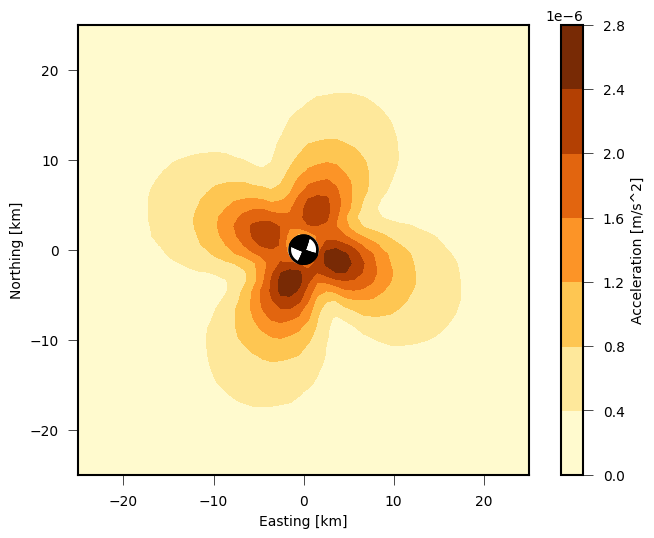

In [2]:
# location where gf stores are located to
gf_store_superdirs = "gf_stores"

engine = gf.LocalEngine(store_superdirs=[gf_store_superdirs])
# scenario setup is hard-coded in the make_scenario() function
source, targets, store_id, norths, easts, stf_spec = make_scenario(engine)

print(source)

# model raw displacement seismograms
response = engine.process(source, targets)

# show some computational infos
print(response.stats)

# convolve displacement seismograms with STF and convert to acceleration
values = post_process(response, norths, easts, stf_spec)

print('Maximum PGA: %g m/s^2' % num.max(values))

plot_shakemap(source, norths, easts, values, 'gf_shakemap.pdf')